In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
import pandas as pd
import numpy as np
import string
import re
import spacy
from nltk.corpus import stopwords
!pip install wordninja
import wordninja
import nltk
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')

     |████████████████████████████████| 541 kB 5.1 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=7a318ba335f3625009c3d100512ed012545e538ca289e57b6f58ef739d6f0c21
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
df = pd.read_csv('train.csv')
df.drop(['Id'], axis=1,inplace=True)
df.shape

(6136, 13)

In [7]:
X = df[["Review"]]
Y = df[['Polarity']]  #'Components', 'Delivery and Customer Support','Design and Aesthetics', 'Dimensions', 'Features', 'Functionality',
                      #'Installation', 'Material', 'Price', 'Quality', 'Usability', 

In [8]:
#remove punctuations, digits, double spaces, split combined words, lemmetization using pos
def prep(df):

    df.loc[:,"preprocessed"]= df["Review"].str.lower().str.translate(str.maketrans('\n',' ',string.punctuation)) 
    df.loc[:,"preprocessed"] = df["preprocessed"].apply(lambda x: re.sub('[0-9]+','',x))                         
    df.loc[:,"preprocessed"] = df["preprocessed"].apply(lambda x: re.sub(' +',' ',x))                            
    df.loc[:,"preprocessed"] = df["preprocessed"].apply(lambda x: (' '.join([' '.join(wordninja.split(tok)) for 
                                                                    tok in x.split(' ')])).split(' '))
    comment_words = [j for i in df.preprocessed.values for j in i if not len(j)>2 ]
    df.loc[:,"preprocessed"] = df['preprocessed'].progress_apply(lambda x: ' '.join([tok for tok in x if tok not in comment_words]))
  
    return df

In [9]:
X_prep = prep(X)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [10]:
X_prep.head()

,Review,preprocessed
0,For some reason everybody complains and I'm co...,for some reason everybody complains and compla...
1,"I like everything about it, great choice of sp...",like everything about great choice spray patte...
2,Excellent ceiling fan brace. Easy to install a...,excellent ceiling fan brace easy install and w...
3,Work great easy to use . No issues at all with...,work great easy use issues all with hanging fan
4,I would recommend this product because it is p...,would recommend this product because perfect f...


In [11]:
# Get the lists of sentences and their labels.
sentences = X_prep.preprocessed.values
labels = Y.values

### BERT Tokenizer

In [13]:
!pip install transformers
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

     |████████████████████████████████| 3.4 MB 4.5 MB/s 
     |████████████████████████████████| 895 kB 40.1 MB/s 
     |████████████████████████████████| 3.3 MB 41.5 MB/s 
     |████████████████████████████████| 596 kB 60.4 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Convert to Required Format

In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  for some reason everybody complains and complaining now about toilet that just bought for some reason its not ceiling from the tank the pedestal cant get sealed without cracking the toilet support design for some reason very unhappy with his toilet never buy american standard again
Token IDs: [101, 2005, 2070, 3114, 7955, 17612, 2015, 1998, 17949, 2085, 2055, 11848, 2008, 2074, 4149, 2005, 2070, 3114, 2049, 2025, 5894, 2013, 1996, 4951, 1996, 24496, 2064, 2102, 2131, 10203, 2302, 15729, 1996, 11848, 2490, 2640, 2005, 2070, 3114, 2200, 12511, 2007, 2010, 11848, 2196, 4965, 2137, 3115, 2153, 102]


In [16]:
from collections import Counter
# Counter([len(sen) for sen in input_ids])

In [15]:
#padding
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 100

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 100 values...

Padding token: "[PAD]", ID: 0

Done.


In [16]:
# Create attention masks
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [33]:
#Train Test split
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.2)
                                             

In [34]:
# Convert all inputs and labels into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [36]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [37]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-3, 
                  eps = 1e-8
                )

In [38]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [25]:
# import numpy as np
# from sklearn.metrics import log_loss 
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [39]:
import numpy as np
from sklearn.metrics import log_loss 
def flat_logloss(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return log_loss(labels_flat,pred_flat)

In [40]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [41]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #clear the gradients
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        # Clip th norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_logloss(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  LoggLoss: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    154.    Elapsed: 0:00:20.
  Batch    80  of    154.    Elapsed: 0:00:40.
  Batch   120  of    154.    Elapsed: 0:01:00.

  Average training loss: 0.75
  Training epcoh took: 0:01:17

Running Validation...
  LoggLoss: 7.76
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    154.    Elapsed: 0:00:21.
  Batch    80  of    154.    Elapsed: 0:00:41.
  Batch   120  of    154.    Elapsed: 0:01:02.

  Average training loss: 0.63
  Training epcoh took: 0:01:20

Running Validation...
  LoggLoss: 7.76
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    154.    Elapsed: 0:00:21.
  Batch    80  of    154.    Elapsed: 0:00:42.
  Batch   120  of    154.    Elapsed: 0:01:03.

  Average training loss: 0.62
  Training epcoh took: 0:01:21

Running Validation...
  LoggLoss: 7.76
  Validation took: 0:00:07

======== Epoch 4 / 4 ========
Training...
  Batch    40  of 

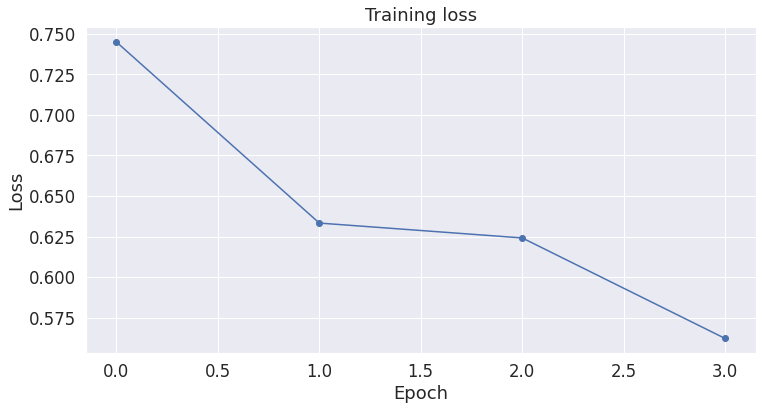

In [42]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()